In [1]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from utils import load_and_clean_data, normalize 
from utils import compare_datasets , compute_common_states , quantize_valves, compute_ccdf

In [2]:
sensor_cols = [
    # --- P1: Boiler sensors ---
    "P1_FT01",   # flow (mmH2O)
    "P1_FT02",   # flow (mmH2O)
    "P1_FT03",   # flow (mmH2O)
    "P1_FT01Z",  # flow converted from FT01 (l/h)
    "P1_FT02Z",  # flow converted from FT02 (l/h)
    "P1_FT03Z",  # flow converted from FT03 (l/h)
    "P1_LIT01",  # level (mm)
    "P1_PIT01",  # pressure (bar)
    "P1_PIT02",  # pressure (bar)
    "P1_TIT01",  # temperature (°C)
    "P1_TIT02",  # temperature (°C)

    # --- P2: Turbine sensors ---
    "P2_24Vdc",    # DCS 24V input voltage (V)
    "P2_SIT01",    # speed (RPM)
    "P2_VIBTR01",  # vibration (µm)
    "P2_VIBTR02",  # vibration (µm)
    "P2_VIBTR03",  # vibration (µm)
    "P2_VIBTR04",  # vibration (µm)
    "P2_VT01",     # key phasor phase-lag (rad/s)

    # --- P3: Water-treatment sensors ---
    "P3_FIT01",  # flow into upper tank (digital scale)
    "P3_LIT01",  # upper tank level (%)
    "P3_PIT01",  # inlet pressure (digital scale)
]
actuators = [
    # --- P1: Boiler actuator feedbacks ---
    "P1_FCV01Z",  # flow valve 01 position (%)
    "P1_FCV02Z",  # flow valve 02 position (%)
    "P1_FCV03Z",  # flow valve 03 position (%)
    "P1_LCV01Z",  # level control valve position (%)
    "P1_PCV01Z",  # pressure control valve 01 position (%)
    "P1_PCV02Z",  # pressure control valve 02 position (%)
    "P1_PP01AR",  # main water pump A running (0/1)
    "P1_PP01BR",  # main water pump B running (0/1)
    "P1_PP02R",   # heating water pump running (0/1)
]


In [3]:

train_files = sorted(glob("../hai-22.04/train1.csv"))
test_files = sorted(glob("../hai-22.04/test1.csv"))
attack_cols = ['Attack']

In [4]:
train_df, test_df = load_and_clean_data(train_files, test_files, attack_cols)



=== Step 1: Loading & Cleaning Data ===
Loading ../hai-22.04/train1.csv...
  Original shape: (93601, 88)
Loading ../hai-22.04/test1.csv...
  After removing attacks: (85515, 88)
Final training data shape: (93601, 87)
Final test data shape: (171915, 87)


In [7]:
# return normalized sensors only
train_quantized, test_quantized = normalize(train_df[sensor_cols], test_df[sensor_cols])


===Normalizing & Quantizing (Q=None) ===
Data ranges before normalization:
  Train: min=-3.19, max=19886.00
  Test: min=-3.29, max=19878.00


In [8]:
ks_statistics_without_states = compare_datasets(train_quantized, test_quantized) # without state

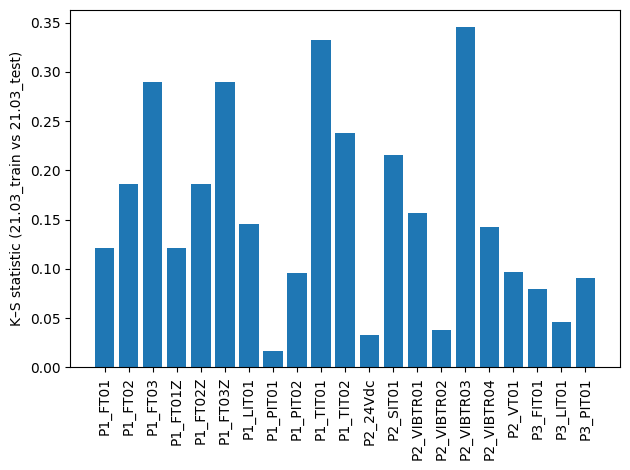

In [26]:

plt.bar(range(len(ks_statistics_without_states)), list(ks_statistics_without_states.values()))
plt.xticks(range(len(ks_statistics_without_states)), list(ks_statistics_without_states.keys()), rotation=90)
plt.ylabel("K–S statistic (21.03_train vs 21.03_test)")
plt.tight_layout()
plt.savefig('ks_statistics_without_states.png', dpi=300, bbox_inches='tight')


In [10]:
a_train_df = train_df.copy()
a_test_df = test_df.copy()

In [12]:
a_train_df = quantize_valves(a_train_df, actuators, ignore=["P1_PP01AR","P1_PP01BR","P1_PP02R"], step=5) # mutating df
print(a_train_df[actuators])
a_test_df = quantize_valves(a_test_df, actuators, ignore=["P1_PP01AR","P1_PP01BR","P1_PP02R"], step=5) # mutating df

       P1_FCV01Z  P1_FCV02Z  P1_FCV03Z  P1_LCV01Z  P1_PCV01Z  P1_PCV02Z  \
0           10.0       50.0       50.0       20.0       25.0       10.0   
1           15.0       50.0       50.0       20.0       25.0       10.0   
2           15.0       50.0       50.0       20.0       25.0       10.0   
3           15.0       50.0       50.0       20.0       25.0       10.0   
4           15.0       45.0       50.0       20.0       25.0       10.0   
...          ...        ...        ...        ...        ...        ...   
93596       15.0       95.0       50.0       15.0       30.0       10.0   
93597       15.0       95.0       50.0       15.0       30.0       10.0   
93598       15.0       95.0       50.0       15.0       30.0       10.0   
93599       15.0       95.0       50.0       15.0       30.0       10.0   
93600       15.0       95.0       50.0       15.0       30.0       10.0   

       P1_PP01AR  P1_PP01BR  P1_PP02R  
0            0.0          0         1  
1            0.0   

In [15]:
train_s, test_s, common_states = compute_common_states(a_train_df, a_test_df, actuators)


=== Computing Common States ===
978 842
Common states: 549


In [16]:
train_coverage_by_test = len(common_states) / len(train_s)
test_coverage_by_train = len(common_states) / len(test_s)

In [17]:
print("Train coverage by Test: {:.2f}%".format(train_coverage_by_test * 100))
print("Test coverage by Train: {:.2f}%".format(test_coverage_by_train * 100))

Train coverage by Test: 56.13%
Test coverage by Train: 65.20%


In [18]:
# returns only normalized sensors
a_train_df_normalized, a_test_df_normalized = normalize(a_train_df[sensor_cols], a_test_df[sensor_cols], Q=None)


===Normalizing & Quantizing (Q=None) ===
Data ranges before normalization:
  Train: min=-3.19, max=19886.00
  Test: min=-3.29, max=19878.00


In [19]:
# For each common state, get all matching sensor values
ks_statistics_per_state = {}

for state in common_states:
    train_mask = (a_train_df[actuators] == pd.Series(state, index=actuators)).all(axis=1)
    train_matching_rows = a_train_df_normalized[train_mask]
    #train_matching_rows[sensor_cols]
    test_mask = (a_test_df[actuators] == pd.Series(state, index=actuators)).all(axis=1)
    test_matching_rows = a_test_df_normalized[test_mask]

    ks_statistics_per_state[state] = compare_datasets(train_matching_rows[sensor_cols], test_matching_rows[sensor_cols])

# Example: print sensor values for the first state

In [20]:
ks_df = pd.DataFrame(ks_statistics_per_state).T

In [21]:
# Compute mean KS per sensor
avg_ks_per_sensor = ks_df.mean(axis=0).sort_values(ascending=False)

print("Average KS per sensor:")
print(avg_ks_per_sensor)

Average KS per sensor:
P1_TIT01      0.789231
P2_SIT01      0.728793
P1_FT03       0.720442
P1_FT03Z      0.719107
P1_TIT02      0.712616
P1_LIT01      0.702496
P3_LIT01      0.644635
P1_PIT01      0.575705
P2_VIBTR03    0.571055
P1_FT01Z      0.547168
P1_FT01       0.545046
P3_FIT01      0.518893
P3_PIT01      0.491727
P2_VIBTR04    0.454614
P2_VIBTR01    0.421638
P1_PIT02      0.413811
P1_FT02       0.393683
P1_FT02Z      0.389150
P2_VT01       0.371704
P2_VIBTR02    0.358606
P2_24Vdc      0.331304
dtype: float64


In [22]:

# Collect all sensor rows for common states from both train and test
all_train_sensor_rows = []
all_test_sensor_rows = []

for state in common_states:
    # Find all rows in a_train_df that match this state
    train_mask = (a_train_df[actuators] == pd.Series(state, index=actuators)).all(axis=1)
    train_matching_rows = a_train_df.loc[train_mask, sensor_cols]
    
    # Add state identifier to each row
    train_matching_rows = train_matching_rows.copy()
    train_matching_rows['state'] = str(state)
    
    all_train_sensor_rows.append(train_matching_rows)
    
    # Find all rows in a_test_df that match this state
    test_mask = (a_test_df[actuators] == pd.Series(state, index=actuators)).all(axis=1)
    test_matching_rows = a_test_df.loc[test_mask, sensor_cols]
    
    # Add state identifier to each row
    test_matching_rows = test_matching_rows.copy()
    test_matching_rows['state'] = str(state)
    
    all_test_sensor_rows.append(test_matching_rows)

# Combine all sensor data into DataFrames
train_sensor_data_df = pd.concat(all_train_sensor_rows, ignore_index=True)
test_sensor_data_df = pd.concat(all_test_sensor_rows, ignore_index=True)

print(f"Train shape: {train_sensor_data_df.shape}")
print(f"Test shape: {test_sensor_data_df.shape}")

Train shape: (79702, 22)
Test shape: (163589, 22)


In [23]:
ks_statistic_with_states = compare_datasets(train_sensor_data_df[sensor_cols], test_sensor_data_df[sensor_cols])

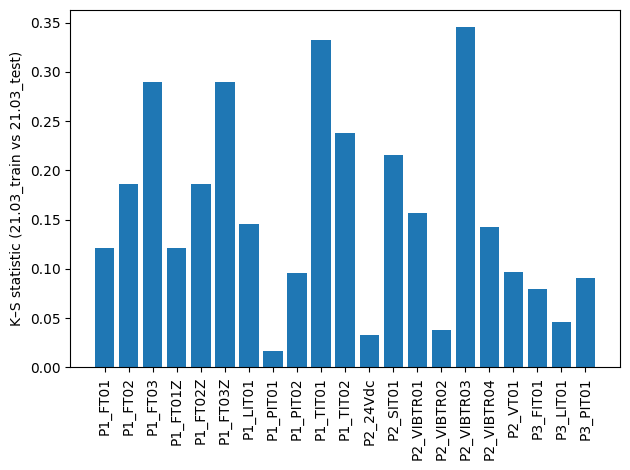

In [29]:

plt.bar(range(len(ks_statistics_without_states)), list(ks_statistics_without_states.values()))
plt.xticks(range(len(ks_statistics_without_states)), list(ks_statistics_without_states.keys()), rotation=90)
plt.ylabel("K–S statistic (21.03_train vs 21.03_test)")
plt.tight_layout()
plt.savefig('ks_statistics_with_states.png', dpi=300, bbox_inches='tight')

In [24]:
x1, y1 = compute_ccdf(list(ks_statistic_with_states.values()))
x2, y2 = compute_ccdf(list(ks_statistics_without_states.values()))

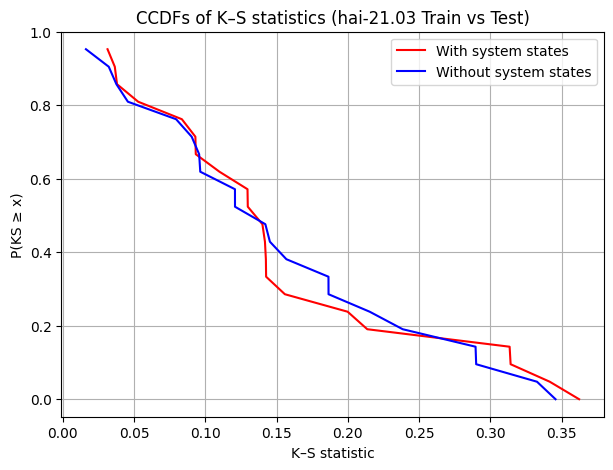

In [28]:
plt.figure(figsize=(7,5))
plt.plot(x1, y1, label='With system states', color='red')
plt.plot(x2, y2, label='Without system states', color='blue')
plt.xlabel('K–S statistic')
plt.ylabel('P(KS ≥ x)')
plt.title('CCDFs of K–S statistics (hai-21.03 Train vs Test)')
plt.legend()
plt.grid(True)
plt.savefig('ccdf-21.png', dpi=300, bbox_inches='tight')